## Inverse Kinematics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import math as m
import random
import csv
import cv2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.regression.linear_model as sm
import time
import matplotlib.patches as mpatches
from PIL import Image, ImageDraw, ImageFont
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# length of manipulators 20, 12, 7
l1 = l2 = l3 = 7

Instructions for updating:
non-resource variables are not supported in the long term


Generating the Work Space

In [2]:
def threeLinkManipulatorFile():
    # Generating data for each row in the dataset
    data = []
    for i in range(1, 150000):
        # Generating random joint angles within specified ranges
        q1 = round(random.uniform(0, m.pi), 2)
        q2 = round(random.uniform(-m.pi, 0), 2)
        q3 = round(random.uniform(-m.pi / 2, m.pi / 2))

        # Calculating end-effector position and orientation
        theta_o = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
        x_s = round(l1 * m.cos(q1) + l2 * m.cos(q1 + q2) + l3 * m.cos(q1 + q2 + q3), 2)
        y_s = round(l1 * m.sin(q1) + l2 * m.sin(q1 + q2) + l3 * m.sin(q1 + q2 + q3), 2)
        data.append([x_s, y_s, theta_o, q1, q2, q3])

    # Creating a DataFrame from the data
    df = pd.DataFrame(data, columns=['x_scaled', 'y_scaled', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated'])

    # Writing the DataFrame to a CSV file
    df.to_csv('Three Link.csv', index = False)

# Uncomment the following line to actually generate the dataset
threeLinkManipulatorFile()

Visualising the Work Space

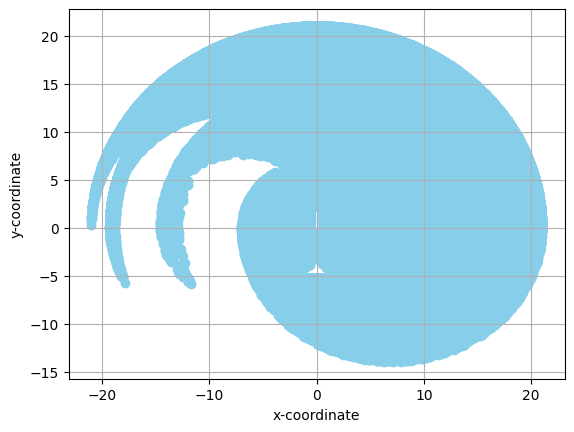

In [3]:
def displayWorkSpace():
    data = pd.read_csv('Three Link.csv')
    plt.scatter(data['x_scaled'], data['y_scaled'], color = 'skyblue')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.grid()

displayWorkSpace()

Text(0.5, 1.0, 'Work Space of the 3 Link Manipulator')

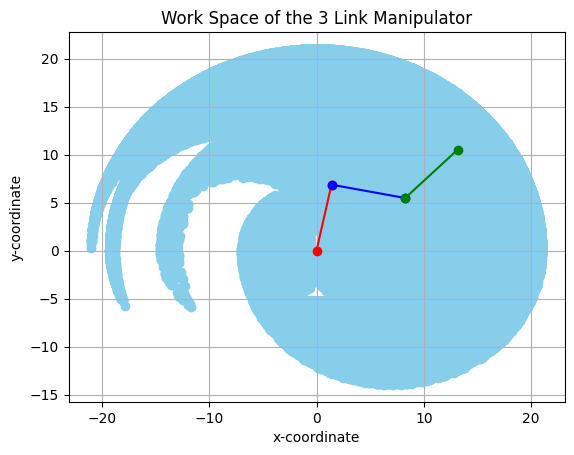

In [4]:
displayWorkSpace()
point_1_x = l1 * m.cos(1.37)
point_1_y = l1 * m.sin(1.37)
point_2_x = l1 * m.cos(1.37) + l2 * m.cos(1.37 - 1.57)
point_2_y = l1 * m.sin(1.37) + l2 * m.sin(1.37 - 1.57)
point_3_x = l1 * m.cos(1.37) + l2 * m.cos(1.37 - 1.57) + l3 * m.cos(1.37 - 1.57 + 1)
point_3_y = l1 * m.sin(1.37) + l2 * m.sin(1.37 - 1.57) + l3 * m.sin(1.37 - 1.57 + 1)
x_values_1 = [0, point_1_x]
y_values_1 = [0, point_1_y]
plt.plot(x_values_1, y_values_1, 'ro', linestyle='-')
x_values_2 = [point_1_x, point_2_x]
y_values_2 = [point_1_y, point_2_y]
plt.plot(x_values_2, y_values_2, 'bo', linestyle='-')
x_values_3 = [point_2_x, point_3_x]
y_values_3 = [point_2_y, point_3_y]
plt.plot(x_values_3, y_values_3, 'go', linestyle='-')
plt.title("Work Space of the 3 Link Manipulator")

Training the Artificial Neural Network Model

In [5]:
data = pd.read_csv('Three Link.csv')

# Splitting training and testing dataset
x = data.iloc[:, 0:3].values
y = data.iloc[:, 3:].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

# Model
classifier = Sequential()
classifier.add(Dense(units = 3, input_dim = 3, kernel_initializer = 'uniform'))
classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'linear'))
classifier.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])

# Training model
history = classifier.fit(x_train, y_train, epochs = 150, validation_split = 0.1, shuffle = True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 107999 samples, validate on 12000 samples
Epoch 1/150
107552/107999 [============================>.] - ETA: 0s - loss: 0.1466 - acc: 0.9377

c:\Users\saatv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


107999/107999 [==============================] - 4s 34us/sample - loss: 0.1461 - acc: 0.9378 - val_loss: 0.0409 - val_acc: 0.9542
Epoch 2/150
107999/107999 [==============================] - 3s 31us/sample - loss: 0.0323 - acc: 0.9637 - val_loss: 0.0261 - val_acc: 0.9656
Epoch 3/150
107999/107999 [==============================] - 3s 32us/sample - loss: 0.0256 - acc: 0.9700 - val_loss: 0.0316 - val_acc: 0.9645
Epoch 4/150
107999/107999 [==============================] - 3s 32us/sample - loss: 0.0216 - acc: 0.9737 - val_loss: 0.0261 - val_acc: 0.9705
Epoch 5/150
107999/107999 [==============================] - 7s 69us/sample - loss: 0.0185 - acc: 0.9775 - val_loss: 0.0278 - val_acc: 0.9648
Epoch 6/150
107999/107999 [==============================] - 8s 73us/sample - loss: 0.0171 - acc: 0.9796 - val_loss: 0.0152 - val_acc: 0.9757
Epoch 7/150
107999/107999 [==============================] - 8s 71us/sample - loss: 0.0156 - acc: 0.9811 - val_loss: 0.0160 - val_acc: 0.9725
Epoch 8/150
107999

Model Evaluation

In [6]:
test_loss, test_acc = classifier.evaluate(x_test, y_test)
print('Testing the Model :')
print('Testing Loss =', test_loss)
print('Testing Accuracy =', test_acc)

Testing the Model :
Testing Loss = 0.006694873219976823
Testing Accuracy = 0.9913


Plot of Model Accuracy

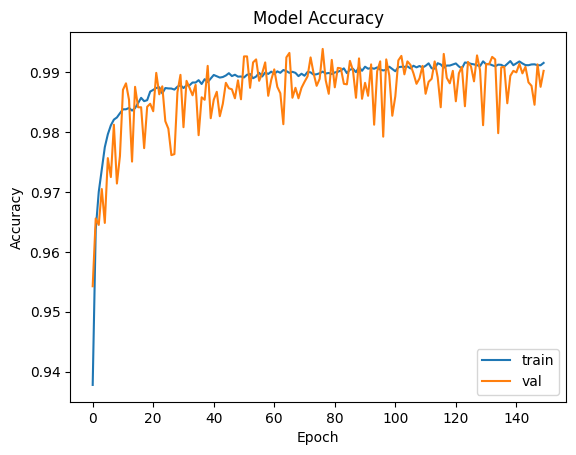

<Figure size 2200x2200 with 0 Axes>

In [7]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.figure(figsize=(22,22))
plt.show()
# plt.savefig('NN-Model_Accuracy.png')

Plot of Model Loss

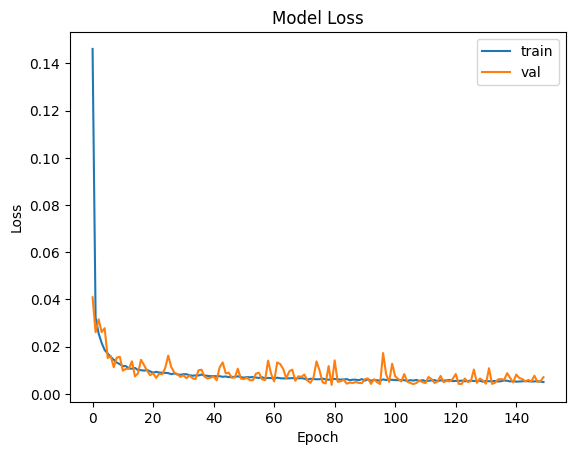

<Figure size 2200x2200 with 0 Axes>

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.figure(figsize=(22,22))
plt.show()
# plt.savefig('NN-Model_Loss.png')

Plot of Mean Square Error

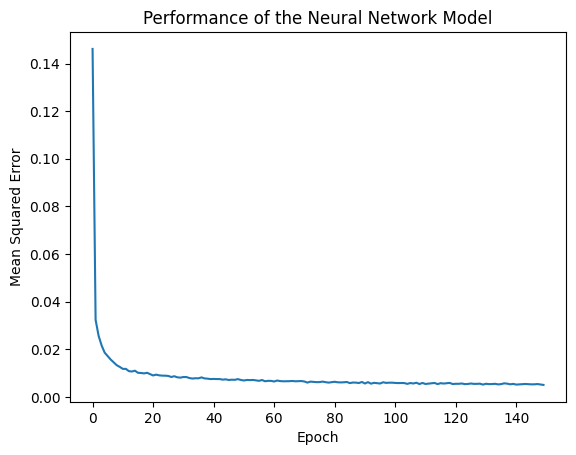

<Figure size 2200x2200 with 0 Axes>

In [9]:
plt.plot(history.history['loss'])
plt.title('Performance of the Neural Network Model')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.figure(figsize=(22,22))
plt.show()

Function for plotting a square representing the Confined Work Space

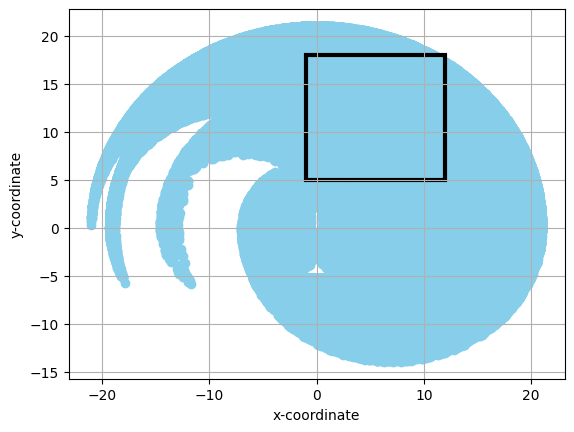

In [10]:
xmin = -1
xmax = 12
ymin = 5
ymax = 18

def displayConfinedWorkSpace():
    rect=mpatches.Rectangle((xmin,ymin),13,13, 
                            fill = False,
                            color = "black",
                            linewidth = 3)
    plt.gca().add_patch(rect)

displayWorkSpace()
displayConfinedWorkSpace()

## GENERATING A PLOT FROM INPUT CSV FILE

Generating a CSV File for a Circle

In [11]:
def circleFile():
    with open('Random Generate_Circle.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        Xc = 10
        Yc = 10
        r = 5
        data_points = 100
        points = np.linspace(0,360,num = data_points)
        x = []
        y = []
        for p in points:
            i=Xc + r * m.cos(np.radians(p))
            x.append(i)
            j=Yc + r * m.sin(np.radians(p))
            y.append(j)

        xmin = -1
        xmax = 12
        ymin = 5
        ymax = 18

        min_xe = np.min(x)
        max_xe = np.max(x)
        min_ye = np.min(y)
        max_ye = np.max(y)

        scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
        scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))
            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)     
    csvFile.close()

circleFile()

c:\Users\saatv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Plot a Circle Using its CSV File

<Figure size 1500x1500 with 0 Axes>

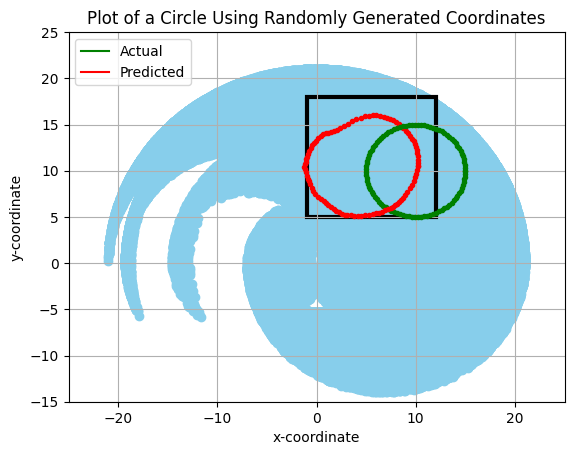

<Figure size 1500x1500 with 0 Axes>

In [12]:
filename = 'Random Generate_Circle.csv'
data = np.loadtxt(filename, delimiter=",", skiprows=1)

x = [row[0] for row in data]
y = [row[1] for row in data]

x_s = [row[12] for row in data]
y_s = [row[13] for row in data]

displayWorkSpace()
displayConfinedWorkSpace()
for i in range(len(data)):
    plt.plot(x[i], y[i], 'go', markersize = 3)
    plt.plot(x_s[i], y_s[i], 'ro', markersize = 3)
    plt.xlim([-25, 25])
    plt.ylim([-15, 25])
    
plt.plot(20, 20, 'g', label='Actual')
plt.plot(20, 20, 'r', label='Predicted')
plt.title('Plot of a Circle Using Randomly Generated Coordinates')
plt.legend(loc='upper left')
plt.figure(figsize=(15,15))
# plt.savefig('Random Generate_Circle Plot.png')

In [13]:
def getPerformanceModel(filename):
    data=pd.read_csv(filename)

    X_true=data['x_original']
    X_pred=data['x_predicted']
    Y_true=data['y_original']
    Y_pred=data['y_predicted']
    q1_true=data['q1_estimated']
    q1_pred=data['q1_predicted']
    q2_true=data['q2_estimated']
    q2_pred=data['q2_predicted']
    q3_true=data['q3_estimated']
    q3_pred=data['q3_predicted']
    theta_true=data['theta_scaled']
    theta_pred=data['theta_predicted']

    mse_x=mean_squared_error(X_true,X_pred)
    mse_y=mean_squared_error(Y_true,Y_pred) 
    mse_q1=mean_squared_error(q1_true,q1_pred)
    mse_q2=mean_squared_error(q2_true,q2_pred) 
    mse_q3=mean_squared_error(q3_true,q3_pred)
    mse_theta=mean_squared_error(theta_true,theta_pred) 
    print('Mean Squared Error in x  :', mse_x) 
    print('Mean Squared Error in y  :', mse_y)
    print('Mean Squared Error in q1 :', mse_q1) 
    print('Mean Squared Error in q2 :', mse_q2)
    print('Mean Squared Error in q3 :', mse_q3)
    print('Mean Squared Error in theta :', mse_theta)
    print()

    rmse_x = m.sqrt(mse_x)
    rmse_y = m.sqrt(mse_y)
    rmse_q1 = m.sqrt(mse_q1)
    rmse_q2 = m.sqrt(mse_q2)
    rmse_q3 = m.sqrt(mse_q3)
    rmse_theta = m.sqrt(mse_theta)
    print('Root Mean Squared Error in x :', rmse_x) 
    print('Root Mean Squared Error in y :', rmse_y)
    print('Root Mean Squared Error in q1 :', rmse_q1) 
    print('Root Mean Squared Error in q2 :', rmse_q2)
    print('Root Mean Squared Error in q3 :', rmse_q3)
    print('Root Mean Squared Error in theta :', rmse_theta)
    print()

    mae_x=mean_absolute_error(X_true,X_pred)
    mae_y=mean_absolute_error(Y_true,Y_pred)
    mae_q1=mean_absolute_error(q1_true,q1_pred)
    mae_q2=mean_absolute_error(q2_true,q2_pred)
    mae_q3=mean_absolute_error(q3_true,q3_pred)
    mae_theta=mean_absolute_error(theta_true,theta_pred)
    print('Mean Absolute Error in x :', mae_x) 
    print('Mean Absolute Error in y :', mae_y)
    print('Mean Absolute Error in q1 :', mae_q1) 
    print('Mean Absolute Error in q2 :', mae_q2)
    print('Mean Absolute Error in q3 :', mae_q3)
    print('Mean Absolute Error in theta :', mae_theta)
    print()

    print('R2 Score for x :', r2_score(X_true, X_pred)) 
    print('R2 Score for y :', r2_score(Y_true, Y_pred))
    print('R2 Score for q1 :', r2_score(q1_true, q1_pred)) 
    print('R2 Score for q2 :', r2_score(q2_true, q2_pred))
    print('R2 Score for q3 :', r2_score(q3_true, q3_pred)) 
    print('R2 Score for theta :', r2_score(theta_true, theta_pred))
    print()

In [14]:
## Performance of Model for Circle
getPerformanceModel('Random Generate_Circle.csv')

Mean Squared Error in x  : 0.2829524715621863
Mean Squared Error in y  : 0.10691755941502654
Mean Squared Error in q1 : 1.882755840732161
Mean Squared Error in q2 : 4.861818098110602e-07
Mean Squared Error in q3 : 1.882705292032749
Mean Squared Error in theta : 0.6196193855699069

Root Mean Squared Error in x : 0.5319327697765821
Root Mean Squared Error in y : 0.3269825062828691
Root Mean Squared Error in q1 : 1.3721355037794776
Root Mean Squared Error in q2 : 0.0006972673876003812
Root Mean Squared Error in q3 : 1.3721170839373544
Root Mean Squared Error in theta : 0.7871590598919045

Mean Absolute Error in x : 0.3872285216985778
Mean Absolute Error in y : 0.2736890531006835
Mean Absolute Error in q1 : 1.17972451667882
Mean Absolute Error in q2 : 0.000488807581012951
Mean Absolute Error in q3 : 1.1796414799222172
Mean Absolute Error in theta : 0.6412197248803809

R2 Score for x : 0.9775834841305457
R2 Score for y : 0.9913601972189877
R2 Score for q1 : -7.874282733757225
R2 Score for q

Generating a CSV File for the word "MANIT"

In [34]:
def manitFile():
    x = []
    y = []
    # for M
    arr=np.linspace(7,10,100)
    for j in arr:
        i = 7
        x.append(i-1)
        y.append(j)

    arr=np.linspace(7,8,100)
    for i in arr:
        j = -3*i + 31
        x.append(i-1)
        y.append(j)

    arr=np.linspace(8,9,100)
    for i in arr:
        j = 3*i - 17
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(7,10,100)
    for j in arr:
        i = 9
        x.append(i-1)
        y.append(j)

    # for A
    arr=np.linspace(10,11,100)
    for i in arr:
        j = 3*i - 23
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(11,12,100)
    for i in arr:
        j= -3*i + 43
        x.append(i-1)
        y.append(j)

    arr=np.linspace(10,12,100)
    for i in arr:
        j = 8
        x.append(i-1)
        y.append(j)

    # for N
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 13
        x.append(i-1)
        y.append(j)

    arr=np.linspace(13,15,100)
    for i in arr:
        j = -1.5*i + 29.5
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 15
        x.append(i-1)
        y.append(j)


    # for I
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 16
        x.append(i-1)
        y.append(j)
        
    # for T
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 17
        x.append(i)
        y.append(j)
            
    arr=np.linspace(16,18,100)
    for i in arr:
        j=10
        x.append(i)
        y.append(j)

    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_xe = np.min(x)
    max_xe = np.max(x)
    min_ye = np.min(y)
    max_ye = np.max(y)

    scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
    scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

    with open('Random Generate_MANIT.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))

            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)
    csvFile.close()
manitFile()

Function for Plotting (After Transformation of Axes and Scaling) Using the CSV File

In [25]:
def plotCoordinateFile(FilePath, PlotTitle):
    filename = FilePath
    data = np.loadtxt(filename, delimiter = ",", skiprows = 1)

    x = [row[0] for row in data]
    y = [row[1] for row in data]

    x_s = [row[12] for row in data]
    y_s = [row[13] for row in data]
    
    i = 1
    displayWorkSpace()
    displayConfinedWorkSpace()

    for i in range(len(data)):
        plt.xlim([-25,30])
        plt.ylim([-15,20])
        plt.plot(x[i], y[i], 'go', markersize = 1.5)
        plt.plot(x_s[i], y_s[i], 'ro', markersize = 1.5)
    
    plt.plot(20, 20, 'g', label='Actual')
    plt.plot(20, 20, 'r', label='Predicted')
    plt.title(PlotTitle)
    plt.legend(loc='upper left')
    plt.figure(figsize=(15,15))

Plot the word MANIT Using its CSV File after Scaling and Transformation of Axes

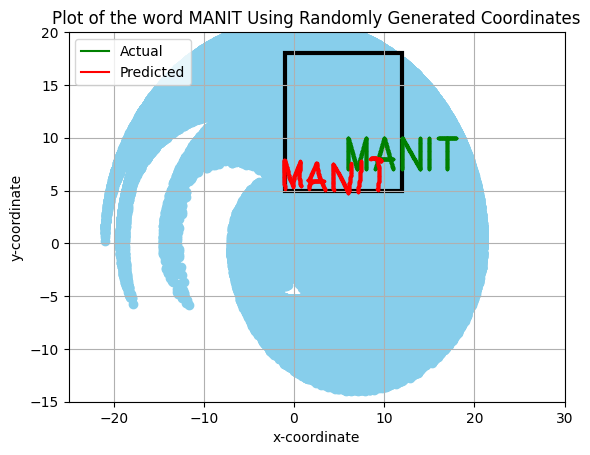

<Figure size 1500x1500 with 0 Axes>

In [35]:
plotCoordinateFile("Random Generate_MANIT.csv", 'Plot of the word MANIT Using Randomly Generated Coordinates')

In [36]:
getPerformanceModel("Random Generate_MANIT.csv")

Mean Squared Error in x  : 0.16228446982646982
Mean Squared Error in y  : 0.08492496270396271
Mean Squared Error in q1 : 1.5659699691384952
Mean Squared Error in q2 : 1.1162253039328694e-06
Mean Squared Error in q3 : 1.5659212172423174
Mean Squared Error in theta : 0.3260937255902465

Root Mean Squared Error in x : 0.4028454664340531
Root Mean Squared Error in y : 0.2914188784275355
Root Mean Squared Error in q1 : 1.2513872179059906
Root Mean Squared Error in q2 : 0.0010565156430138029
Root Mean Squared Error in q3 : 1.2513677386133613
Root Mean Squared Error in theta : 0.5710461676521843

Mean Absolute Error in x : 0.2763796425796426
Mean Absolute Error in y : 0.23441328671328673
Mean Absolute Error in q1 : 1.0926052626190896
Mean Absolute Error in q2 : 0.0005824184062069558
Mean Absolute Error in q3 : 1.0925797083236415
Mean Absolute Error in theta : 0.4642775780928647

R2 Score for x : 0.9877817628275416
R2 Score for y : 0.898150310843503
R2 Score for q1 : -5.324192683241212
R2 Scor

Generating a CSV File for the word "ROBOT"

In [63]:
def makeCircle(Xcentre, Ycentre, radius, start, end, x, y):
    Xc = Xcentre
    Yc = Ycentre
    r = radius
    data_points = 100
    points = np.linspace(start,end,num =data_points)
    for p in points:
        i=Xc + r*m.cos(np.radians(p))
        j=Yc + r*m.sin(np.radians(p))
        x.append(i)
        y.append(j)

def robotFile():
    x = []
    y = []

    # for R
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 5
        x.append(i)
        y.append(j)
    
    makeCircle(5, 9, 1, -90, 90, x, y)

    arr=np.linspace(5,6,100)
    for i in arr:
        j= -i + 13
        x.append(i)
        y.append(j)

    # for O
    makeCircle(8, 8, 1, 0, 360, x, y)

    # for B
    arr=np.linspace(6,10,100) # 6, 10
    for j in arr:
        i= 10 # 10
        x.append(i)
        y.append(j)
        
    makeCircle(10, 7, 1, -90, 90, x, y) # makeCircle(10, 8, 2, -90, 90, csvFile)
        
    makeCircle(10, 9, 1, -90, 90, x, y) # makeCircle(10, 12, 2, -90, 90, csvFile)
        
    # for O
    makeCircle(13, 8, 1, 0, 360, x, y)

    # for T
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 15
        x.append(i)
        y.append(j)
    
    arr=np.linspace(14,16,100)
    for i in arr:
        j=10
        x.append(i)
        y.append(j)


    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_xe = np.min(x)
    max_xe = np.max(x)
    min_ye = np.min(y)
    max_ye = np.max(y)

    scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
    scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

    with open('Random Generate_ROBOT.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))

            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)
    csvFile.close()
robotFile()

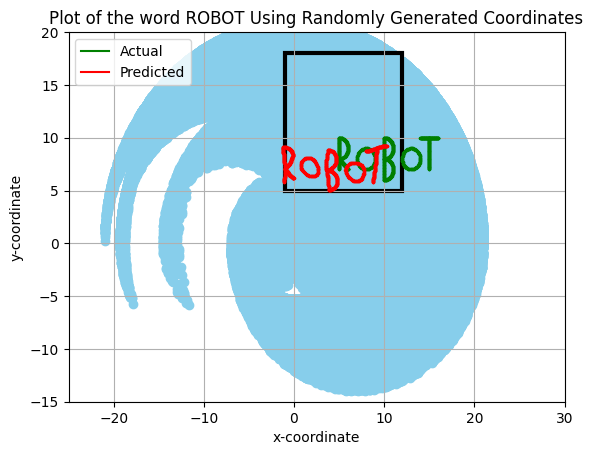

<Figure size 1500x1500 with 0 Axes>

In [64]:
plotCoordinateFile("Random Generate_ROBOT.csv", 'Plot of the word ROBOT Using Randomly Generated Coordinates')

In [83]:
getPerformanceModel("Random Generate_ROBOT.csv")

Mean Squared Error in x  : 0.10708053271973623
Mean Squared Error in y  : 0.059833565723364575
Mean Squared Error in q1 : 2.3820479368600087
Mean Squared Error in q2 : 2.666992849305343e-07
Mean Squared Error in q3 : 2.38195925493901
Mean Squared Error in theta : 0.34450116055282953

Root Mean Squared Error in x : 0.3272316193764537
Root Mean Squared Error in y : 0.24460900581001627
Root Mean Squared Error in q1 : 1.5433884594812832
Root Mean Squared Error in q2 : 0.0005164293610267858
Root Mean Squared Error in q3 : 1.5433597295961206
Root Mean Squared Error in theta : 0.5869422122771794

Mean Absolute Error in x : 0.21402659745559663
Mean Absolute Error in y : 0.1879471160211349
Mean Absolute Error in q1 : 1.375188637561698
Mean Absolute Error in q2 : 0.000419502136391373
Mean Absolute Error in q3 : 1.3751676270216653
Mean Absolute Error in theta : 0.45240552650685756

R2 Score for x : 0.9917398731983885
R2 Score for y : 0.9501619082586694
R2 Score for q1 : -10.634600221690729
R2 Sco

Plot a Circle Using its CSV File after Scaling and Transformation of Axes

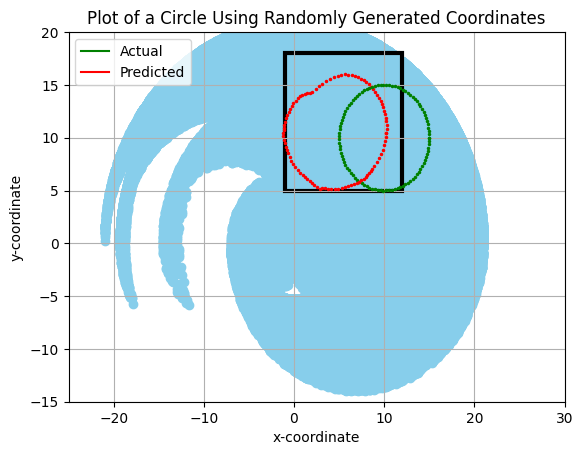

<Figure size 1500x1500 with 0 Axes>

In [37]:
plotCoordinateFile("Random Generate_Circle.csv", 'Plot of a Circle Using Randomly Generated Coordinates')

In [38]:
getPerformanceModel("Random Generate_Circle.csv")

Mean Squared Error in x  : 0.2829524715621863
Mean Squared Error in y  : 0.10691755941502654
Mean Squared Error in q1 : 1.882755840732161
Mean Squared Error in q2 : 4.861818098110602e-07
Mean Squared Error in q3 : 1.882705292032749
Mean Squared Error in theta : 0.6196193855699069

Root Mean Squared Error in x : 0.5319327697765821
Root Mean Squared Error in y : 0.3269825062828691
Root Mean Squared Error in q1 : 1.3721355037794776
Root Mean Squared Error in q2 : 0.0006972673876003812
Root Mean Squared Error in q3 : 1.3721170839373544
Root Mean Squared Error in theta : 0.7871590598919045

Mean Absolute Error in x : 0.3872285216985778
Mean Absolute Error in y : 0.2736890531006835
Mean Absolute Error in q1 : 1.17972451667882
Mean Absolute Error in q2 : 0.000488807581012951
Mean Absolute Error in q3 : 1.1796414799222172
Mean Absolute Error in theta : 0.6412197248803809

R2 Score for x : 0.9775834841305457
R2 Score for y : 0.9913601972189877
R2 Score for q1 : -7.874282733757225
R2 Score for q

## GENERATING A PLOT FROM INPUT IMAGE FILE

Function for Generating a CSV File from an Image

In [39]:
# Not working as expected
def generateCoordinateFile(FilePath, name):
    # Read the image
    image = cv2.imread(FilePath)

    # Define the target color (in BGR format)
    target_color = (0, 0, 0)

    # Find the coordinates of pixels with the target color
    x = []
    y = []
    height, width, _ = image.shape
    for j in range(height):
        for i in range(width):
            pixel_color = tuple(image[j, i])
            if pixel_color == target_color:
                x.append(i)
                y.append(height - j)

    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_x = np.min(x)
    max_x = np.max(x)
    min_y = np.min(y)
    max_y = np.max(y)

    scaling_factor_x = 10 * (xmax - xmin) / (max_x - min_x)
    scaling_factor_y = 10 * (ymax - ymin) / (max_y - min_y)

    # Output Coordinates in CSV file
    output_file = "Image Generate_" + str(name) + ".csv"
    with open(output_file, "w", newline='') as csvfile:
        # Define the header row
        fieldnames = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']

        # Create a CSV writer object
        csv_writer = csv.DictWriter(csvfile, fieldnames = fieldnames)

        # Write the header row
        csv_writer.writeheader()

        # Write the coordinates to the CSV file
        for k in range(len(x)):
            # Assuming you need to calculate q1, q2, q3, thetae based on x, y (modify accordingly)
            i = x[k] / 10
            j = y[k] / 10
            theta=m.degrees(m.atan(j / i))

            new_x=np.array([[i, j, theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            x_s = (x_p - min_x / 10) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            y_s = (y_p - min_y / 10) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin

            csv_writer.writerow({'x_original': i, 'y_original': j, 'theta_scaled': theta, 'q1_estimated': q1, 'q2_estimated': q2, 'q3_estimated': q3, 'x_predicted': x_p, 'y_predicted': y_p, 'theta_predicted': theta_p, 'q1_predicted': q1_p, 'q2_predicted': q2_p, 'q3_predicted': q3_p, 'x_scaled': x_s, 'y_scaled': y_s})

Plotting the word "MANIT" from it's Image by generating a CSV File

In [75]:
generateCoordinateFile('Image_MANIT.png', "MANIT")

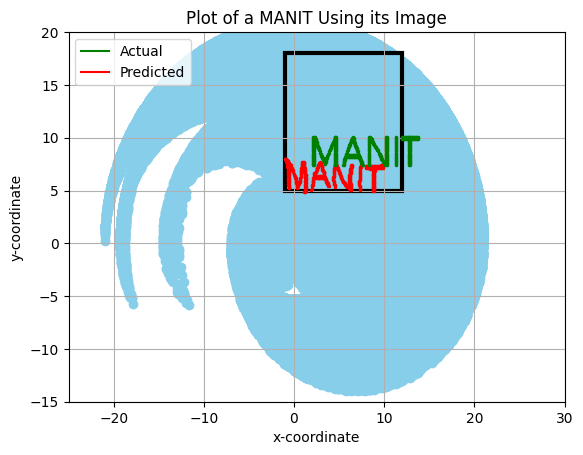

<Figure size 1500x1500 with 0 Axes>

In [76]:
plotCoordinateFile("Image Generate_MANIT.csv", 'Plot of a MANIT Using its Image')

In [77]:
getPerformanceModel("Image Generate_MANIT.csv")

Mean Squared Error in x  : 0.04060110497237567
Mean Squared Error in y  : 0.10626721915285452
Mean Squared Error in q1 : 3.230419378237538
Mean Squared Error in q2 : 2.0372360647123614e-07
Mean Squared Error in q3 : 3.230402239830374
Mean Squared Error in theta : 0.5582918407572273

Root Mean Squared Error in x : 0.20149715872035434
Root Mean Squared Error in y : 0.32598653216483425
Root Mean Squared Error in q1 : 1.7973367459209022
Root Mean Squared Error in q2 : 0.0004513575151376524
Root Mean Squared Error in q3 : 1.797331978191668
Root Mean Squared Error in theta : 0.7471892937918927

Mean Absolute Error in x : 0.16486187845303865
Mean Absolute Error in y : 0.25762430939226516
Mean Absolute Error in q1 : 1.6014540615571828
Mean Absolute Error in q2 : 0.00037593514596583023
Mean Absolute Error in q3 : 1.6014232225041456
Mean Absolute Error in theta : 0.6479892861124634

R2 Score for x : 0.9969216227274027
R2 Score for y : 0.8469009190503717
R2 Score for q1 : -19.890156250642743
R2 S

Plotting the word "ROBOT" from it's Image by generating a CSV File

In [69]:
generateCoordinateFile('Image_ROBOT.png', "ROBOT")

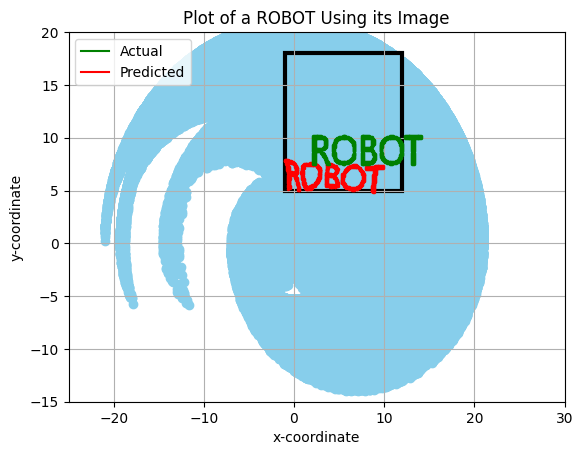

<Figure size 1500x1500 with 0 Axes>

In [70]:
plotCoordinateFile("Image Generate_ROBOT.csv", 'Plot of a ROBOT Using its Image')

In [78]:
getPerformanceModel("Image Generate_ROBOT.csv")

Mean Squared Error in x  : 0.04045581127733026
Mean Squared Error in y  : 0.10334085155350979
Mean Squared Error in q1 : 3.0883170764926438
Mean Squared Error in q2 : 2.1798705416996337e-07
Mean Squared Error in q3 : 3.0883033926205945
Mean Squared Error in theta : 0.576495361570876

Root Mean Squared Error in x : 0.20113630024769338
Root Mean Squared Error in y : 0.3214667192004637
Root Mean Squared Error in q1 : 1.7573608270621728
Root Mean Squared Error in q2 : 0.0004668908375305339
Root Mean Squared Error in q3 : 1.7573569337560866
Root Mean Squared Error in theta : 0.759272916394939

Mean Absolute Error in x : 0.16008055235903335
Mean Absolute Error in y : 0.2563636363636364
Mean Absolute Error in q1 : 1.5712192295963967
Mean Absolute Error in q2 : 0.00038326033310691755
Mean Absolute Error in q3 : 1.5712129182952472
Mean Absolute Error in theta : 0.6522014270008156

R2 Score for x : 0.9970096438136268
R2 Score for y : 0.8689072209143757
R2 Score for q1 : -18.40638087579698
R2 Sco

Plotting a Circle from it's Image by generating a CSV File

In [79]:
generateCoordinateFile('Image_Circle.png', "Circle")

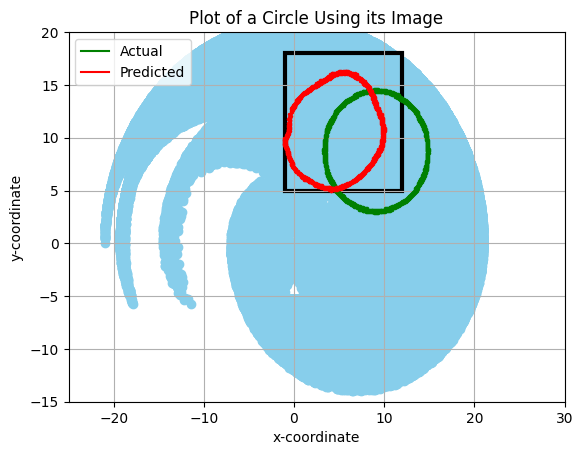

<Figure size 1500x1500 with 0 Axes>

In [80]:
plotCoordinateFile("Image Generate_Circle.csv", 'Plot of a Circle Using its Image')

In [81]:
getPerformanceModel("Image Generate_Circle.csv")

Mean Squared Error in x  : 0.09837799999999998
Mean Squared Error in y  : 0.4156783478260869
Mean Squared Error in q1 : 2.4440385587523665
Mean Squared Error in q2 : 0.00010918108722393738
Mean Squared Error in q3 : 2.444175033171989
Mean Squared Error in theta : 2.173753635993462

Root Mean Squared Error in x : 0.31365267414769477
Root Mean Squared Error in y : 0.6447312213830558
Root Mean Squared Error in q1 : 1.5633421118719877
Root Mean Squared Error in q2 : 0.010448975415031724
Root Mean Squared Error in q3 : 1.5633857595526413
Root Mean Squared Error in theta : 1.4743655028497724

Mean Absolute Error in x : 0.2529304347826086
Mean Absolute Error in y : 0.4523565217391305
Mean Absolute Error in q1 : 1.2924508330180051
Mean Absolute Error in q2 : 0.002528537222180427
Mean Absolute Error in q3 : 1.2939158046887096
Mean Absolute Error in theta : 1.2122192839553387

R2 Score for x : 0.9940313303887783
R2 Score for y : 0.974431416995993
R2 Score for q1 : -6.919923789808764
R2 Score for

Plot a Triangle from its Image by generating a CSV File

In [82]:
generateCoordinateFile('Image_Triangle.png', "Triangle")

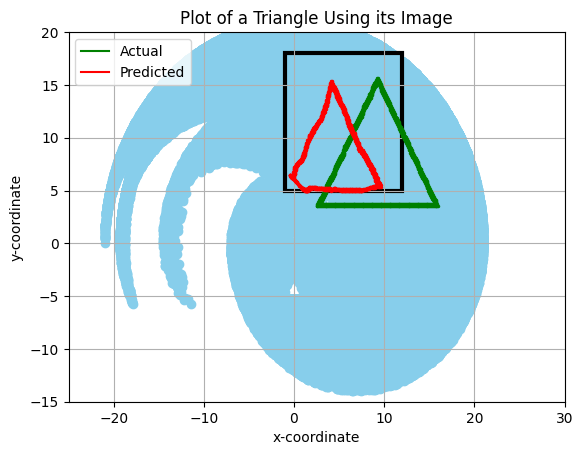

<Figure size 1500x1500 with 0 Axes>

In [83]:
plotCoordinateFile("Image Generate_Triangle.csv", 'Plot of a Triangle Using its Image')

In [84]:
getPerformanceModel("Image Generate_Triangle.csv")

Mean Squared Error in x  : 0.07727231503579952
Mean Squared Error in y  : 0.2647752585521082
Mean Squared Error in q1 : 1.7767436516207036
Mean Squared Error in q2 : 0.0057135486300510935
Mean Squared Error in q3 : 1.7840119821896814
Mean Squared Error in theta : 1.644382642411847

Root Mean Squared Error in x : 0.27797898308289337
Root Mean Squared Error in y : 0.5145631725571781
Root Mean Squared Error in q1 : 1.3329454796129898
Root Mean Squared Error in q2 : 0.07558801909066735
Root Mean Squared Error in q3 : 1.3356691140359882
Root Mean Squared Error in theta : 1.2823348402082224

Mean Absolute Error in x : 0.2043198090692124
Mean Absolute Error in y : 0.3567621320604614
Mean Absolute Error in q1 : 0.968066506999817
Mean Absolute Error in q2 : 0.027376828780046675
Mean Absolute Error in q3 : 0.9945885349285085
Mean Absolute Error in theta : 1.0863044020704111

R2 Score for x : 0.9946031179629331
R2 Score for y : 0.9831964551842287
R2 Score for q1 : -6.397319947950544
R2 Score for 

Plot a Pentagon from its Image by generating a CSV File

In [85]:
generateCoordinateFile('Image_Pentagon.png', "Pentagon")

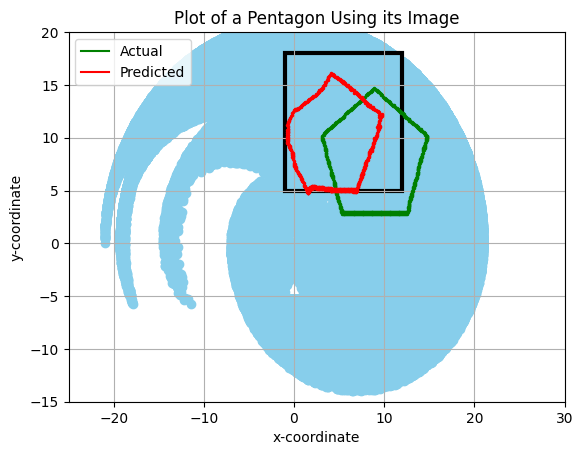

<Figure size 1500x1500 with 0 Axes>

In [86]:
plotCoordinateFile("Image Generate_Pentagon.csv", 'Plot of a Pentagon Using its Image')

In [87]:
getPerformanceModel("Image Generate_Pentagon.csv")

Mean Squared Error in x  : 0.07203877887788777
Mean Squared Error in y  : 0.23393102310231023
Mean Squared Error in q1 : 2.66673751618727
Mean Squared Error in q2 : 0.001865736672327391
Mean Squared Error in q3 : 2.6686171882217042
Mean Squared Error in theta : 1.6740904096406246

Root Mean Squared Error in x : 0.2684004077453829
Root Mean Squared Error in y : 0.483664163549782
Root Mean Squared Error in q1 : 1.633014854858115
Root Mean Squared Error in q2 : 0.04319417405539074
Root Mean Squared Error in q3 : 1.6335902755041438
Root Mean Squared Error in theta : 1.2938664574215628

Mean Absolute Error in x : 0.22051155115511545
Mean Absolute Error in y : 0.3229042904290429
Mean Absolute Error in q1 : 1.3240558607324442
Mean Absolute Error in q2 : 0.013495453122843235
Mean Absolute Error in q3 : 1.336421313328783
Mean Absolute Error in theta : 1.0524273918608458

R2 Score for x : 0.9944305383865335
R2 Score for y : 0.9858424908071165
R2 Score for q1 : -9.203887972091675
R2 Score for q2 

Plot a Square from its Image by generating a CSV File

In [88]:
generateCoordinateFile('Image_Square.png', "Square")

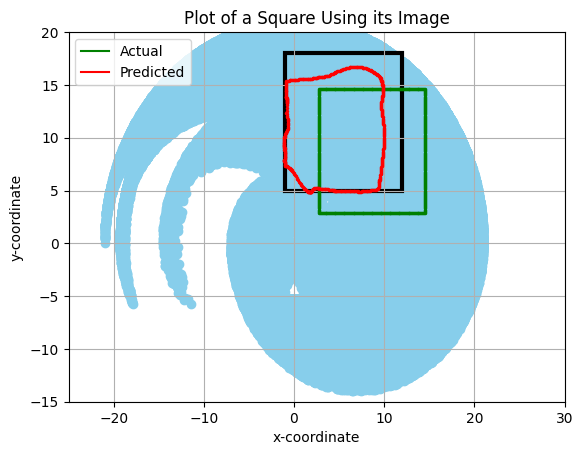

<Figure size 1500x1500 with 0 Axes>

In [89]:
plotCoordinateFile("Image Generate_Square.csv", 'Plot of a Square Using its Image')

In [90]:
getPerformanceModel("Image Generate_Square.csv")

Mean Squared Error in x  : 0.18273034188034193
Mean Squared Error in y  : 0.41659444444444454
Mean Squared Error in q1 : 1.7676084491966773
Mean Squared Error in q2 : 0.007389522353782365
Mean Squared Error in q3 : 1.7781040967364952
Mean Squared Error in theta : 2.374810200524835

Root Mean Squared Error in x : 0.4274696970316632
Root Mean Squared Error in y : 0.6454412788507136
Root Mean Squared Error in q1 : 1.3295143659233912
Root Mean Squared Error in q2 : 0.08596233101645374
Root Mean Squared Error in q3 : 1.3334556973279972
Root Mean Squared Error in theta : 1.5410419204307308

Mean Absolute Error in x : 0.3131196581196581
Mean Absolute Error in y : 0.46786324786324796
Mean Absolute Error in q1 : 0.9792479971655557
Mean Absolute Error in q2 : 0.03140715213067844
Mean Absolute Error in q3 : 1.0099064461932714
Mean Absolute Error in theta : 1.2571588204022193

R2 Score for x : 0.9919910730758461
R2 Score for y : 0.9817409937056382
R2 Score for q1 : -3.6739417862363863
R2 Score for

Plot a Hexagon from its Image by generating a CSV File

In [91]:
generateCoordinateFile('Image_Hexagon.png', "Hexagon")

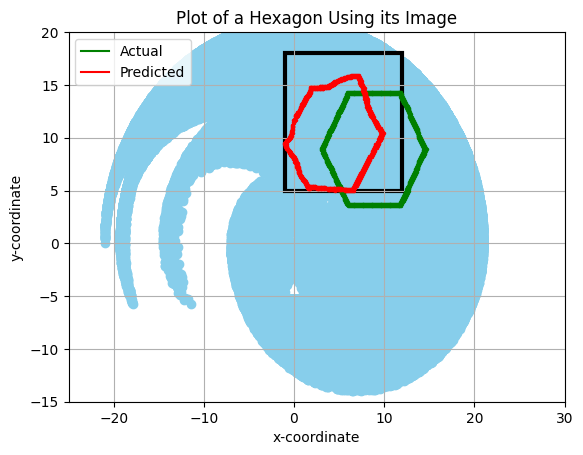

<Figure size 1500x1500 with 0 Axes>

In [92]:
plotCoordinateFile("Image Generate_Hexagon.csv", 'Plot of a Hexagon Using its Image')

In [93]:
getPerformanceModel("Image Generate_Hexagon.csv")

Mean Squared Error in x  : 0.06172180180180179
Mean Squared Error in y  : 0.3793133333333334
Mean Squared Error in q1 : 2.6073971862602017
Mean Squared Error in q2 : 3.930140600803027e-06
Mean Squared Error in q3 : 2.6074768598138403
Mean Squared Error in theta : 2.1509429546531753

Root Mean Squared Error in x : 0.24843872846599782
Root Mean Squared Error in y : 0.6158841882475417
Root Mean Squared Error in q1 : 1.6147436905776105
Root Mean Squared Error in q2 : 0.0019824582217043128
Root Mean Squared Error in q3 : 1.6147683610393908
Root Mean Squared Error in theta : 1.4666093394810955

Mean Absolute Error in x : 0.20679279279279275
Mean Absolute Error in y : 0.4256936936936937
Mean Absolute Error in q1 : 1.350595745268306
Mean Absolute Error in q2 : 0.0006369561493746871
Mean Absolute Error in q3 : 1.3506797732143834
Mean Absolute Error in theta : 1.208553503400402

R2 Score for x : 0.9956198831592457
R2 Score for y : 0.97512007274889
R2 Score for q1 : -9.641923189298419
R2 Score fo

## GENERATING A PLOT FROM INPUT TEXT

In [45]:
def text_to_image(text, font_size, image_width, 
                  image_height, output_path) :

    # Creating a blank image with the specified dimensions
    image = Image.new("RGB", 
                      (image_width, image_height), 
                      (255, 255, 255))

    # Creating a draw object
    draw = ImageDraw.Draw(image)

    # Load the font
    font = ImageFont.truetype("arial.ttf", font_size)

    # Calculating the textsize
    _, _, text_width, text_height = draw.textbbox((0, 0), 
                                                  text=text, 
                                                  font=font)

    # Calculating the position of the centre of the text
    x = 60
    y = image_height - text_height - 30

    # Draw the text on the image
    draw.text((x, y), text, font = font, fill = (0, 0, 0))

    # Save the image to the specified output path
    image.save(output_path)

Plotting the Word "SAATVIK" from Text Input

In [95]:
text_to_image("SAATVIK", 30, 300, 100, "Text Generate_SAATVIK.png")

In [96]:
generateCoordinateFile('Text Generate_SAATVIK.png', "SAATVIK")

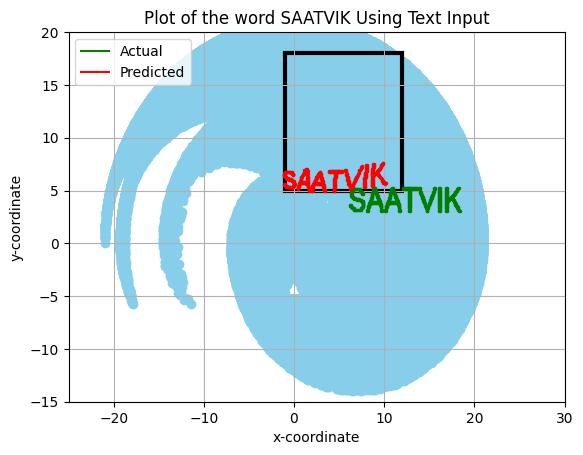

<Figure size 1500x1500 with 0 Axes>

In [97]:
plotCoordinateFile("Image Generate_SAATVIK.csv", 'Plot of the word SAATVIK Using Text Input')

In [98]:
getPerformanceModel("Image Generate_SAATVIK.csv")

Mean Squared Error in x  : 0.16768479087452481
Mean Squared Error in y  : 0.135645247148289
Mean Squared Error in q1 : 2.759645026594785
Mean Squared Error in q2 : 2.871828779933145e-07
Mean Squared Error in q3 : 2.75956813696994
Mean Squared Error in theta : 0.9473051999131642

Root Mean Squared Error in x : 0.40949333434687896
Root Mean Squared Error in y : 0.36830048486024153
Root Mean Squared Error in q1 : 1.661217934707781
Root Mean Squared Error in q2 : 0.0005358944653505152
Root Mean Squared Error in q3 : 1.661194792000607
Root Mean Squared Error in theta : 0.9732960494696176

Mean Absolute Error in x : 0.3458555133079849
Mean Absolute Error in y : 0.2533079847908745
Mean Absolute Error in q1 : 1.4442781857998481
Mean Absolute Error in q2 : 0.0004309741830693156
Mean Absolute Error in q3 : 1.4442509877103324
Mean Absolute Error in theta : 0.837370232492387

R2 Score for x : 0.9872806677582113
R2 Score for y : 0.66806107994246
R2 Score for q1 : -12.225239339446482
R2 Score for q2

Plotting the Word "MANIT" from Text Input

In [46]:
text_to_image("MANIT", 30, 300, 100, "Text Generate_MANIT.png")

In [47]:
generateCoordinateFile('Text Generate_MANIT.png', "MANIT")

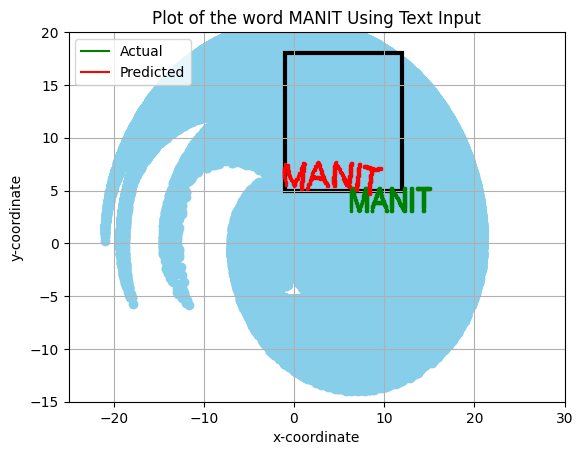

<Figure size 1500x1500 with 0 Axes>

In [48]:
plotCoordinateFile("Image Generate_MANIT.csv", 'Plot of the word MANIT Using Text Input')

In [49]:
getPerformanceModel("Image Generate_MANIT.csv")

Mean Squared Error in x  : 0.013443918918918909
Mean Squared Error in y  : 0.043912387387387376
Mean Squared Error in q1 : 3.297526381676872
Mean Squared Error in q2 : 1.9371488929841397e-07
Mean Squared Error in q3 : 3.297680853139622
Mean Squared Error in theta : 0.5859104509653219

Root Mean Squared Error in x : 0.11594791468120032
Root Mean Squared Error in y : 0.20955282719970011
Root Mean Squared Error in q1 : 1.8159092437885964
Root Mean Squared Error in q2 : 0.0004401305366574943
Root Mean Squared Error in q3 : 1.8159517761051975
Root Mean Squared Error in theta : 0.7654478760603637

Mean Absolute Error in x : 0.09781531531531525
Mean Absolute Error in y : 0.17988738738738735
Mean Absolute Error in q1 : 1.684258023778469
Mean Absolute Error in q2 : 0.0003686250607597209
Mean Absolute Error in q3 : 1.684300105449467
Mean Absolute Error in theta : 0.671071125211748

R2 Score for x : 0.997967860443557
R2 Score for y : 0.8951297444555143
R2 Score for q1 : -31.623966347794244
R2 Sco

Plotting the Word "ROBOT" from Text Input

In [79]:
text_to_image("ROBOT", 30, 300, 100, "Text Generate_ROBOT.png")

In [80]:
generateCoordinateFile('Text Generate_ROBOT.png', "ROBOT")

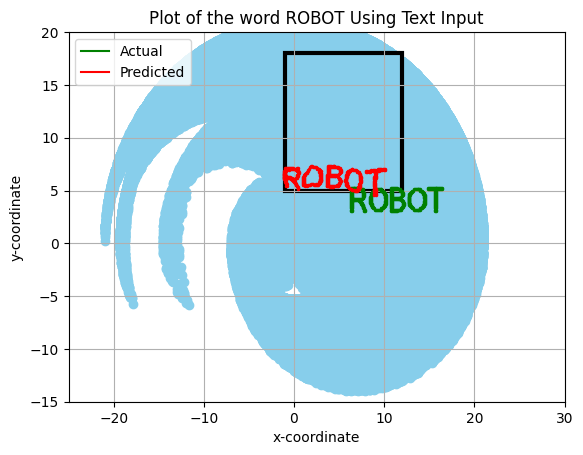

<Figure size 1500x1500 with 0 Axes>

In [81]:
plotCoordinateFile("Image Generate_ROBOT.csv", 'Plot of the word ROBOT Using Text Input')

In [82]:
getPerformanceModel("Image Generate_ROBOT.csv")

Mean Squared Error in x  : 0.033706016597510394
Mean Squared Error in y  : 0.048261618257261406
Mean Squared Error in q1 : 3.102513497672827
Mean Squared Error in q2 : 2.247605470362035e-07
Mean Squared Error in q3 : 3.1025660627502596
Mean Squared Error in theta : 0.7545202649632876

Root Mean Squared Error in x : 0.18359198402302426
Root Mean Squared Error in y : 0.21968527091560192
Root Mean Squared Error in q1 : 1.7613953269135316
Root Mean Squared Error in q2 : 0.0004740891762487343
Root Mean Squared Error in q3 : 1.7614102482812628
Root Mean Squared Error in theta : 0.8686312594900598

Mean Absolute Error in x : 0.13686721991701245
Mean Absolute Error in y : 0.18661825726141076
Mean Absolute Error in q1 : 1.556525382976481
Mean Absolute Error in q2 : 0.00039799980023336314
Mean Absolute Error in q3 : 1.556539853915831
Mean Absolute Error in theta : 0.7483120988914154

R2 Score for x : 0.9963938282320297
R2 Score for y : 0.8932661097287458
R2 Score for q1 : -20.00614870743357
R2 S

Plotting the Word "ROBOTICS" from Text Input

In [103]:
text_to_image("ROBOTICS", 26, 300, 100, "Text Generate_ROBOTICS.png")

In [104]:
generateCoordinateFile('Text Generate_ROBOTICS.png', "ROBOTICS")

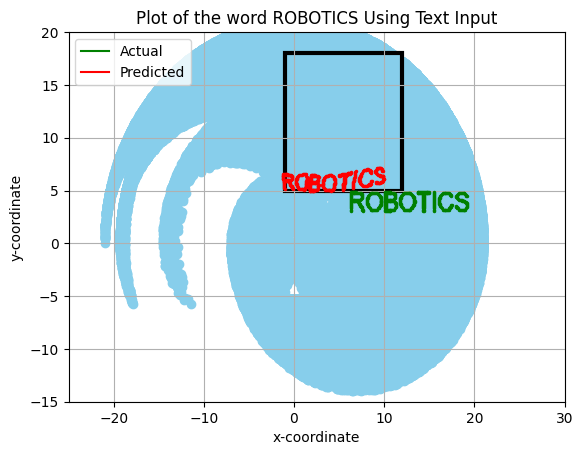

<Figure size 1500x1500 with 0 Axes>

In [105]:
plotCoordinateFile("Image Generate_ROBOTICS.csv", 'Plot of the word ROBOTICS Using Text Input')

In [106]:
getPerformanceModel("Image Generate_ROBOTICS.csv")

Mean Squared Error in x  : 0.16275444444444437
Mean Squared Error in y  : 0.13387066666666667
Mean Squared Error in q1 : 2.8709268823181526
Mean Squared Error in q2 : 2.971707855283735e-07
Mean Squared Error in q3 : 2.87092051187633
Mean Squared Error in theta : 1.2982786643784225

Root Mean Squared Error in x : 0.40342836346053357
Root Mean Squared Error in y : 0.3658834058367046
Root Mean Squared Error in q1 : 1.69438097319291
Root Mean Squared Error in q2 : 0.0005451337317836546
Root Mean Squared Error in q3 : 1.694379093318945
Root Mean Squared Error in theta : 1.1394203194512649

Mean Absolute Error in x : 0.34593333333333326
Mean Absolute Error in y : 0.23457777777777777
Mean Absolute Error in q1 : 1.4874036096682852
Mean Absolute Error in q2 : 0.00042453055422268256
Mean Absolute Error in q3 : 1.4874119155583656
Mean Absolute Error in theta : 0.8923140283772978

R2 Score for x : 0.9886523544626378
R2 Score for y : 0.61763328166713
R2 Score for q1 : -10.776889963504575
R2 Score f

Plotting the Word "3 LINK" from Text Input

In [107]:
text_to_image("3 LINK", 30, 300, 100, "Text Generate_3 LINK.png")

In [108]:
generateCoordinateFile('Text Generate_3 LINK.png', "3 LINK")

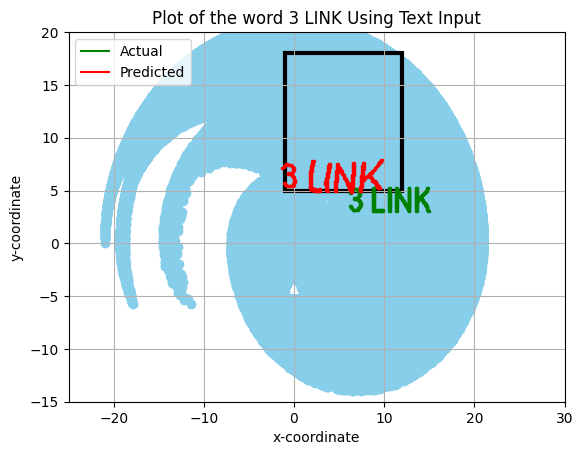

<Figure size 1500x1500 with 0 Axes>

In [109]:
plotCoordinateFile("Image Generate_3 LINK.csv", 'Plot of the word 3 LINK Using Text Input')

In [110]:
getPerformanceModel("Image Generate_3 LINK.csv")

Mean Squared Error in x  : 0.06525543766578254
Mean Squared Error in y  : 0.01166737400530504
Mean Squared Error in q1 : 3.193601642535348
Mean Squared Error in q2 : 2.0249263673281007e-07
Mean Squared Error in q3 : 3.1935763372055272
Mean Squared Error in theta : 0.42952893622831284

Root Mean Squared Error in x : 0.2554514389581365
Root Mean Squared Error in y : 0.10801561926547956
Root Mean Squared Error in q1 : 1.7870650918574142
Root Mean Squared Error in q2 : 0.00044999181851763714
Root Mean Squared Error in q3 : 1.7870580117068184
Root Mean Squared Error in theta : 0.6553845712467702

Mean Absolute Error in x : 0.22925729442970827
Mean Absolute Error in y : 0.07485411140583556
Mean Absolute Error in q1 : 1.6714846230482499
Mean Absolute Error in q2 : 0.0003783585230688069
Mean Absolute Error in q3 : 1.671472859172506
Mean Absolute Error in theta : 0.5044615125681342

R2 Score for x : 0.9889992090078031
R2 Score for y : 0.9722353938276921
R2 Score for q1 : -33.54605886571887
R2 S

Plotting the Word "BHOPAL" from Text Input

In [111]:
text_to_image("BHOPAL", 30, 300, 100, "Text Generate_BHOPAL.png")

In [112]:
generateCoordinateFile('Text Generate_BHOPAL.png', "BHOPAL")

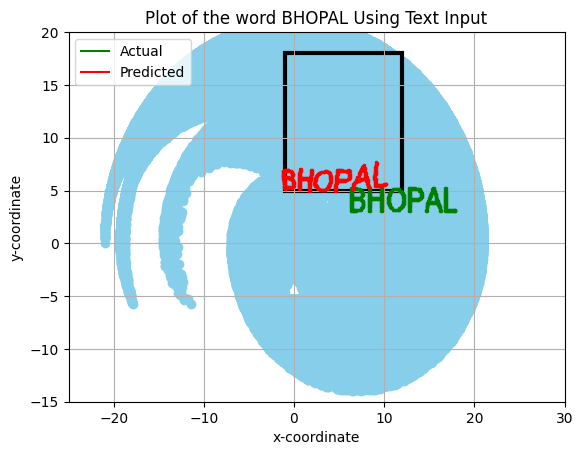

<Figure size 1500x1500 with 0 Axes>

In [113]:
plotCoordinateFile("Image Generate_BHOPAL.csv", 'Plot of the word BHOPAL Using Text Input')

In [114]:
getPerformanceModel("Image Generate_BHOPAL.csv")

Mean Squared Error in x  : 0.12033021201413437
Mean Squared Error in y  : 0.0788720848056537
Mean Squared Error in q1 : 3.1097405156940816
Mean Squared Error in q2 : 2.3576803611603906e-07
Mean Squared Error in q3 : 3.1098424152065833
Mean Squared Error in theta : 0.7936946535864006

Root Mean Squared Error in x : 0.3468864540654973
Root Mean Squared Error in y : 0.28084174334605905
Root Mean Squared Error in q1 : 1.763445637294805
Root Mean Squared Error in q2 : 0.0004855595083159623
Root Mean Squared Error in q3 : 1.7634745292196832
Root Mean Squared Error in theta : 0.8908954223624682

Mean Absolute Error in x : 0.29726148409894004
Mean Absolute Error in y : 0.19519434628975266
Mean Absolute Error in q1 : 1.5334827460091567
Mean Absolute Error in q2 : 0.0004015788484363895
Mean Absolute Error in q3 : 1.5334942966930025
Mean Absolute Error in theta : 0.7919690519074413

R2 Score for x : 0.99035923995113
R2 Score for y : 0.8070248035127133
R2 Score for q1 : -14.245845714363863
R2 Scor

Plotting the Word "RESEARCH" from Text Input

In [115]:
text_to_image("RESEARCH", 26, 300, 100, "Text Generate_RESEARCH.png")

In [116]:
generateCoordinateFile('Text Generate_RESEARCH.png', "RESEARCH")

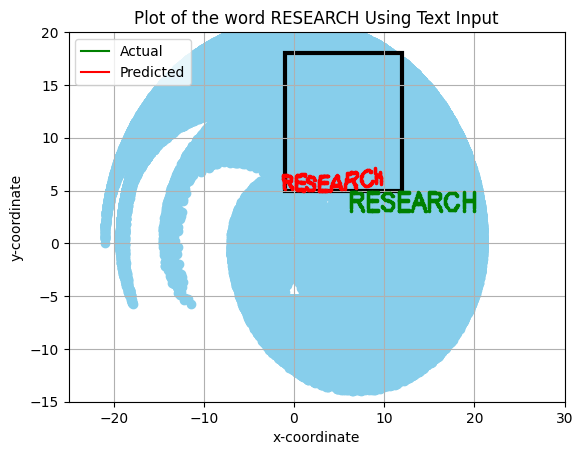

<Figure size 1500x1500 with 0 Axes>

In [117]:
plotCoordinateFile("Image Generate_RESEARCH.csv", 'Plot of the word RESEARCH Using Text Input')

In [118]:
getPerformanceModel("Image Generate_RESEARCH.csv")

Mean Squared Error in x  : 0.14476083650190102
Mean Squared Error in y  : 0.15115551330798482
Mean Squared Error in q1 : 2.7132284018162767
Mean Squared Error in q2 : 6.420040950895157e-07
Mean Squared Error in q3 : 2.7132783060050456
Mean Squared Error in theta : 1.6087784842735267

Root Mean Squared Error in x : 0.38047448863478484
Root Mean Squared Error in y : 0.38878723398278503
Root Mean Squared Error in q1 : 1.6471880286768346
Root Mean Squared Error in q2 : 0.0008012515803975152
Root Mean Squared Error in q3 : 1.647203176904733
Root Mean Squared Error in theta : 1.268376318082897

Mean Absolute Error in x : 0.32205323193916346
Mean Absolute Error in y : 0.2644106463878327
Mean Absolute Error in q1 : 1.40928334384669
Mean Absolute Error in q2 : 0.0005402448293015089
Mean Absolute Error in q3 : 1.4092892940945767
Mean Absolute Error in theta : 0.9833098342151093

R2 Score for x : 0.9911425205217329
R2 Score for y : 0.5610894224710412
R2 Score for q1 : -8.634146936287648
R2 Score 